In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os, random
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from scipy.signal import savgol_filter
from scipy import interpolate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
np.random.seed( 0 )
sns.set_style( "darkgrid" )

## Preprocessing/Cleaning

In [3]:
df = pd.read_parquet("C:\\Users\\lselig\\selig-fa\\finance\\.data\\ratios.parquet")
df["year"] = pd.DatetimeIndex(df["date"]).year
# df = df[df.year >= 2019]
print(df.shape)
print(df.describe())
print(list(df))
print(df.isna().sum())

# lots of missing values, these columns are missing most frequently (> 100k / 350k)
worst_offenders = ["totalDebtToCapitalization", "interestCoverage", "inventoryTurnover", "cashFlowCoverageRatios", "shortTermCoverageRatios",
                   "dividendPaidAndCapexCoverageRatio", "dividendPayoutRatio", "dividendYield"]

df.drop(columns = worst_offenders, inplace = True)
print(df.shape)

df.dropna(inplace = True)
print(df.shape)


qualitative_cols = ["symbol", "date", "period", "year"]
qualitatives = df[qualitative_cols]
df.drop(columns = qualitative_cols, inplace = True)
print(df.shape)


(75828, 58)
        currentRatio    quickRatio     cashRatio  daysOfSalesOutstanding  \
count   69706.000000  6.970600e+04  6.970600e+04            6.541800e+04   
mean       66.094887  2.077921e+03  1.299750e+02            8.581801e+11   
std      4771.105061  3.758537e+05  2.371334e+04            1.947207e+14   
min       -92.134563 -9.116624e+01 -6.977980e+00           -2.280885e+06   
25%         1.068699  6.767321e-01  1.914582e-01            9.948057e+01   
50%         1.913104  1.355501e+00  6.031813e-01            2.007088e+02   
75%         4.173772  3.394295e+00  1.850330e+00            3.148343e+02   
max    791493.095238  9.044764e+07  6.124554e+06            4.964380e+16   

       daysOfInventoryOutstanding  operatingCycle  daysOfPayablesOutstanding  \
count                5.234900e+04    5.178800e+04               5.234900e+04   
mean                 3.029878e+11    3.325508e+11               8.163114e+13   
std                  6.931064e+13    7.070345e+13              

In [4]:
features = df.to_numpy()
# features = df
scaler = StandardScaler()
features =  scaler.fit_transform(features)
features = np.clip(features, -5, 5)
print(features.shape)
n_features = features.shape[1]
print(n_features)
%matplotlib widget 
for i in range(n_features):
    print(i, np.nanmin(features[:, i]), np.nanmax(features[:, i]))
    sns.kdeplot(features[:, i])
plt.title("Distribution of final features")
plt.close()

(35155, 46)
46
0 -5.0 5.0
1 -0.03771331633360139 5.0
2 -0.005822232523870578 5.0
3 -0.007480985662521523 5.0
4 -0.005334302090212797 5.0
5 -0.005385994538010135 5.0
6 -0.005433963057725987 5.0
7 -0.16136017018696389 5.0
8 -5.0 0.0452807879910563
9 -5.0 0.005344530518186123
10 -5.0 0.005344397057571528
11 -5.0 0.005342204060407873
12 -5.0 5.0
13 -5.0 5.0
14 -5.0 5.0
15 -5.0 5.0
16 -5.0 5.0
17 -5.0 5.0
18 -5.0 0.005344530518191355
19 -1.4101603458029748 5.0
20 -5.0 5.0
21 -5.0 5.0
22 -5.0 5.0
23 -5.0 5.0
24 -0.006815817797849523 5.0
25 -0.4811355414584481 5.0
26 -0.06708867282568452 5.0
27 -0.023959445605717538 5.0
28 -0.12133276071003056 5.0
29 -0.33482292645686534 5.0
30 -0.005343188656223408 5.0
31 -5.0 5.0
32 -5.0 0.0055555743806870415
33 -5.0 5.0
34 -5.0 5.0
35 -5.0 5.0
36 -5.0 5.0
37 -0.005337483023824213 5.0
38 -5.0 5.0
39 -5.0 5.0
40 -5.0 5.0
41 -5.0 5.0
42 -0.007785269686692694 5.0
43 -0.005337483023824213 5.0
44 -5.0 5.0
45 -5.0 5.0


                                    currentRatio  quickRatio  cashRatio  \
currentRatio                            1.000000   -0.001872  -0.001591   
quickRatio                             -0.001872    1.000000   0.742105   
cashRatio                              -0.001591    0.742105   1.000000   
daysOfSalesOutstanding                  0.016024   -0.000035  -0.000026   
daysOfInventoryOutstanding              0.004895   -0.000034  -0.000018   
operatingCycle                          0.005089   -0.000034  -0.000018   
daysOfPayablesOutstanding               0.005227   -0.000034  -0.000018   
cashConversionCycle                     0.005055   -0.000034  -0.000018   
grossProfitMargin                       0.002520    0.000043   0.000030   
operatingProfitMargin                  -0.004934    0.000034   0.000018   
pretaxProfitMargin                     -0.004934    0.000034   0.000018   
netProfitMargin                        -0.004926    0.000034   0.000018   
effectiveTaxRate         

<AxesSubplot:>

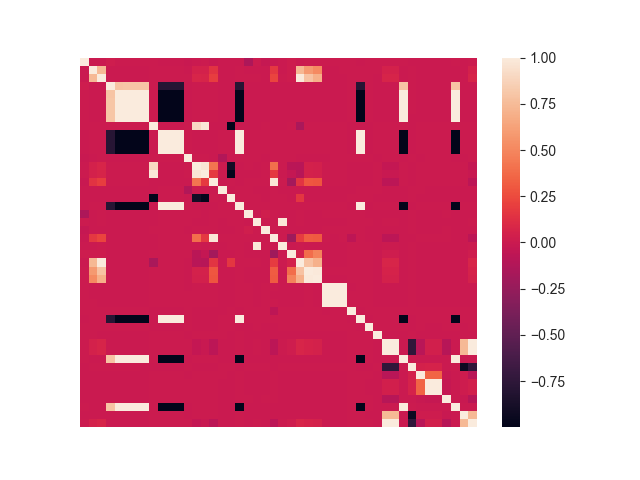

In [5]:
corr = df.corr()
print(corr)
sns.heatmap(corr, annot = False, xticklabels= False, yticklabels=False)


In [6]:
print(features.shape)
pca = PCA(n_components=2)
pca.fit(features.T)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))
components = pca.components_.T
print(components.shape)
# plt.close()
# plt.hist2d(components[:, 0], components[:, 1], bins = 100)
# plt.show()

(35155, 46)
[0.41765131 0.16170069]
0.5793519976321112
(35155, 2)


# Goal: Use clustering to identify potential outliers based on financial ratios

In [7]:
from sklearn.cluster import KMeans, DBSCAN
# from sklearn.cluster import AffinityPropagation

# winners = ["AAPL", "MSFT", "GOOGL"]

clst = KMeans(n_clusters=5, random_state=0).fit(components)
# clst = DBSCAN(eps = 0.0001, min_samples = 10).fit(components)
# clst = AffinityPropagation( random_state=0).fit(components)
labels = clst.labels_.reshape(-1, 1)
# print(qualitatives)
tickers = qualitatives.symbol.values
fig, axs = plt.subplots(1, 2, figsize = (12, 8))
pca_and_labels = np.hstack((components, labels))

def overlay_specific_stock(ticker, ax, color = "C8", show_date = False):
    winners_idx = np.where(tickers == ticker)[0]
    print(winners_idx)
    x = pca_and_labels[winners_idx][:, 0]
    y = pca_and_labels[winners_idx][:, 1]
    ax.scatter(x, y, label = ticker, color = color, zorder = 1)
    if(show_date):
        for idx in winners_idx:
            x = pca_and_labels[idx][0]
            y = pca_and_labels[idx][1]
            ax.text(x, y, s = qualitatives.iloc[idx].year)

# overlay_specific_stock("GOOGL", axs[0], color = "C7")
overlay_specific_stock("GMGI", axs[0], color = "C8", show_date = False)
overlay_specific_stock("GME", axs[0], color = "C9", show_date = False)
# overlay_specific_stock("HDSN", axs[0], color = "C6", show_date = False)


overlay_specific_stock("SNDL", axs[0], color = "C6", show_date = False)
# overlay_specific_stock("MSFT", axs[0], color = "C9")
# overlay_specific_stock("GME", axs[0], color = "C6")
# overlay_specific_stock("TSLA", axs[0], color = "black")
# overlay_specific_stock("GME", axs[0], color = "black", show_date = True)
# overlay_specific_stock("HIVE", axs[0], color = "black", show_date = True)
# overlay_specific_stock("BOXD", axs[0], color = "black", show_date = True)
# overlay_specific_stock("NVCN", axs[0], color = "black", show_date = True)
# overlay_specific_stock("NVTA", axs[0], color = "black", show_date = True)


print(pca_and_labels.shape)
clst.labels_.shape
for g in np.unique(labels):
    idxs = np.where(pca_and_labels[:, 2] == g)[0]
    cluster = pca_and_labels[idxs]
    # print(cluster)
    # for i, c in enumerate(cluster):
        # axs[0].text(c[0], c[1], s = qualitatives.iloc[idxs[i]].symbol)
    axs[0].scatter(cluster[:, 0],  cluster[:, 1], label = g, alpha = 0.8, zorder = -1)
axs[0].set_xlabel("PCA1")
axs[0].set_ylabel("PCA2")
axs[1].hist2d(pca_and_labels[:, 0], pca_and_labels[:, 1], bins = 1000, zorder = -1)
axs[1].set_xlabel("PCA1")
axs[1].set_ylabel("PCA2")
axs[0].legend()
plt.show()
